In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data

In [2]:
_train = pd.read_csv("train.csv")
_test = pd.read_csv("test.csv")

# Make a copy to be modified
train = _train.copy()
test = _test.copy()

In [3]:
train_len = len(train)
print("Training dataset size = {}".format(train_len))
train.head()

Training dataset size = 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_len = len(test)
print("Test dataset size = {}".format(test_len))
test.head()

Test dataset size = 418


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Data Analysis

Like most kernels, we will start by analysing the features from the dataset, one-by-one, focusing on:
- Finding correlations, not only between the feature and survival but also between the features themselves to understand if the information the feature provides is not redundant.
- Creating visualizations that help us understand the data.
- Cleaning the dataset by removing redundant features.
- Filling missing data when needed.
- Converting data types when advantageous (e.g. converting categorical data to numerical).

In [5]:
# Remove PassengerId since it's not a feature
train.drop(columns='PassengerId', inplace=True)
test.drop(columns='PassengerId', inplace=True)

## Missing data

In [6]:
# Concatenate the train and test datasets. Survived is not a feature so we drop it
dataset = pd.concat([train, test], sort=False).drop(columns='Survived')
pd.DataFrame({'No. NaN': dataset.isna().sum(), '%': dataset.isna().sum() / len(dataset)})

,%,No. NaN
Pclass,0.000000,0
Name,0.000000,0
Sex,0.000000,0
Age,0.200917,263
SibSp,0.000000,0
Parch,0.000000,0
Ticket,0.000000,0
Fare,0.000764,1
Cabin,0.774637,1014
Embarked,0.001528,2


Features with missing data:
- **Cabin (~77%)**: Drop. Too much data is missing to fill without introducing a significant amount of noise.
- **Age (~20%)**: Significant amount of data missing, but if it's useful we can try to fill it.
- **Fare (1 data point)**: Keep. Since only one value is missing we can fill it with something simple like a median.
- **Embarked (2 data points)**: Keep. Since only two values are missing we can fill them with something simple like a median.

In [7]:
train.drop(columns='Cabin', inplace=True)
test.drop(columns='Cabin', inplace=True)

## Age

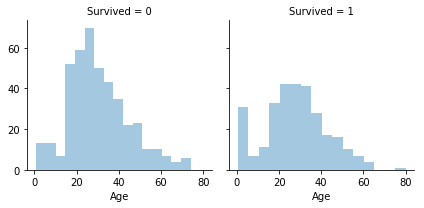

In [8]:
g = sns.FacetGrid(train, col='Survived')
_ = g.map(sns.distplot, 'Age', kde=False)

From the histogram we can already see that children have much better chances of survival. The next table offers more information.

In [9]:
no_age_bins = 10
age_band_series, age_bins = pd.cut(train['Age'], no_age_bins, retbins=True)

survival = (train['Survived'].groupby(age_band_series)
                           .agg(['count', 'sum', 'mean'])
                           .rename(columns={'count': 'Total',
                                            'sum': 'Survived',
                                            'mean': 'Survival Rate'}))
survival

,Total,Survived,Survival Rate
Age,,,
"(0.34, 8.378]",54,36,0.666667
"(8.378, 16.336]",46,19,0.413043
"(16.336, 24.294]",177,63,0.355932
"(24.294, 32.252]",169,65,0.384615
"(32.252, 40.21]",118,52,0.440678
"(40.21, 48.168]",70,24,0.342857
"(48.168, 56.126]",45,21,0.466667
"(56.126, 64.084]",24,9,0.375000
"(64.084, 72.042]",9,0,0.000000


Observation:
- Children (age < 8) indeed have much higher chances of survival (66.7%).
- There are also small spikes in survival for passengers in the following age bands:
    - (32.252, 40.21] - 44.1%;
    - (48.168, 56.126] - 46.7%.
- Apart from children, there is no obvious correlation between age and survival.

### Filing missing Age values

We are going to estimate the age band of passengers whose age is missing using the following features:  Age, Pclass, SibSp, Parch, Sex, and	Title (engineered from Name). Then, we will build three simple models to predict the missing age bands.

In [10]:
# Use both the training and test dataset to fill the missing Age values
fill_age_df = pd.concat([train, test], sort=True)[['Name', 'Age', 'Pclass', 'SibSp', 'Parch', 'Sex']]

# Use the age bins from above
fill_age_df['Age'] = pd.cut(fill_age_df['Age'], age_bins)

# Get the titles of the passengers
fill_age_df['Title'] = fill_age_df['Name'].apply(lambda x: x[x.find(', ') + 1:x.find('.') + 1])

# Now that we have the titles we can drop the names
fill_age_df.drop(columns='Name', inplace=True)

# Encode ages bins and titles in integers 
fill_age_df['Age'] = fill_age_df['Age'].cat.codes
fill_age_df['Title'] = fill_age_df['Title'].astype('category').cat.codes
fill_age_df['Sex'] = fill_age_df['Sex'].astype('category').cat.codes

fill_age_df.head()

,Age,Pclass,SibSp,Parch,Sex,Title
0,2,3,1,0,1,12
1,4,1,1,0,0,13
2,3,3,0,0,0,9
3,4,1,1,0,0,13
4,4,3,0,0,1,12


Three simple classification models to predict the age bands for missing data:
- Logistic regression
- K-nearest neighbors
- Decision tree

In [11]:
X_train = fill_age_df.loc[fill_age_df['Age'] != -1].drop(columns='Age')
Y_train = fill_age_df['Age'].loc[fill_age_df['Age'] != -1]
X = fill_age_df.loc[fill_age_df['Age'] == -1].drop(columns='Age')
print("Training samples shape: {}".format(X_train.shape))
print("Ground-truth shape: {}".format(Y_train.shape))
print("Samples to predict: {}".format(X.shape))

Training samples shape: (1044, 5)
Ground-truth shape: (1044,)
Samples to predict: (265, 5)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression()
logreg_scores = cross_val_score(logreg, X_train, Y_train, cv=3)
print("Logistic Regression cross-validation scores: {:.3f}".format(logreg_scores.mean()))

knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train, Y_train, cv=3)
print("KNeighbors cross-validation scores: {:.3f}".format(knn_scores.mean()))

tree = DecisionTreeClassifier()
tree_scores = cross_val_score(tree, X_train, Y_train, cv=3)
print("Tree Classifier cross-validation scores: {:.3f}".format(tree_scores.mean()))

Logistic Regression cross-validation scores: 0.301
KNeighbors cross-validation scores: 0.300
Tree Classifier cross-validation scores: 0.351


In [13]:
# Make predictions using our best model (Decision Tree)
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_train)

# Compute the per-class/per-age band accuracy
total = np.bincount(Y_train.values, minlength=no_age_bins)
correct = np.bincount(Y_pred[Y_pred == Y_train.values], minlength=no_age_bins)
class_acc = correct / total
pd.DataFrame({'Age band': age_band_series.cat.categories, 'Per class acc.': class_acc})

,Age band,Per class acc.
0,"(0.34, 8.378]",0.957143
1,"(8.378, 16.336]",0.274194
2,"(16.336, 24.294]",0.697080
3,"(24.294, 32.252]",0.396000
4,"(32.252, 40.21]",0.254658
5,"(40.21, 48.168]",0.361111
6,"(48.168, 56.126]",0.246154
7,"(56.126, 64.084]",0.097561
8,"(64.084, 72.042]",0.100000
9,"(72.042, 80.0]",0.000000


None of the models achieves high-accuracy overall; however, if we check the per-class/per-age band accuracy, we see that our best model (Decision Tree) is really good at predicting children - 95.7% accuracy for passengers in the 0 to 8 age band. As discussed previously, this is the most relevant age band; therefore, a low overall accuracy shouldn't be a big issue as long as we have a high accuracy for this age band.

It also shows that the model can make good predictions for passengers within the ages of 16 and 24. A possible explanation is that passengers within this age band are more likely to be traveling with friends or alone, therefore SibSp and Parch are 0.

We can now predict the age band for passengers with missing data:

In [14]:
Y = tree.predict(X)
fill_age_df.loc[fill_age_df['Age'] == -1, 'Age'] = Y

Apply the integer encoded age bands to the train and test datasets.

In [15]:
train['Age'] = fill_age_df.iloc[:train_len, 0]
test['Age'] = fill_age_df.iloc[train_len:, 0]

train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,2,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,4,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,3,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,4,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,4,0,0,373450,8.0500,S


## Sex

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

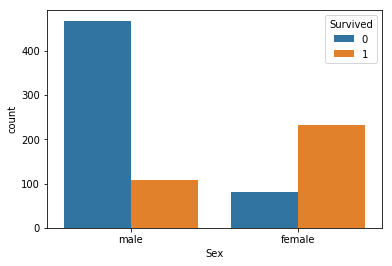

In [16]:
_ = sns.countplot(x='Sex', hue='Survived', data=train)
train.groupby('Sex')['Survived'].mean()

Females have much higher survival rates. One-hot encode `Sex` so the algorithms can handle it.

In [17]:
# One-encode using dummies
train['IsMale'] = pd.get_dummies(train['Sex'], drop_first=True)
test['IsMale'] = pd.get_dummies(test['Sex'], drop_first=True)

# Drop the Sex column
train.drop(columns='Sex', inplace=True)
test.drop(columns='Sex', inplace=True)

## Ticket class (Pclass)

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

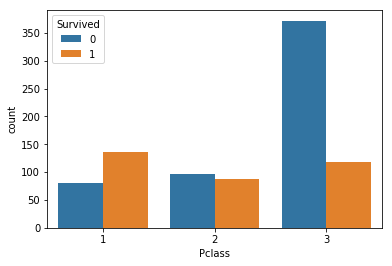

In [18]:
_ = sns.countplot(x='Pclass', hue='Survived', data=train)
train.groupby('Pclass')['Survived'].mean()

Passengers with higher ticket class (lower `Pclass`) have higher chances of survival:
- 1st class: 63%
- 2nd class: 48%
- 3rd class: 24%

Keep the feature as-is, Pclass is already encoded in integers (one-hot encoding would leave out the natural order of ticket class which is an important part of the feature).

## Port of Embarkation (Embarked)

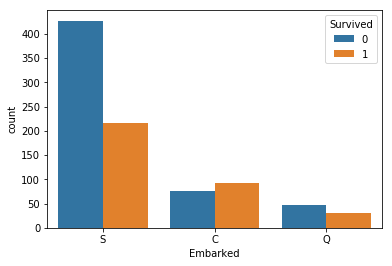

In [19]:
_ = sns.countplot(x='Embarked', hue='Survived', data=train)

After looking at this graph my first thought was that it was a useful feature, we can see that passengers from different ports have varying chances of survival. Great!

Then, after thinking some more I was convinced that there shouldn't be a correlation between port of embarkation and survival. I thought that what this graph shows is just the combination of `IsMale` and `Pclass`...

/home/davidtvs/datascience/kaggle/Titanic/titanic-env/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


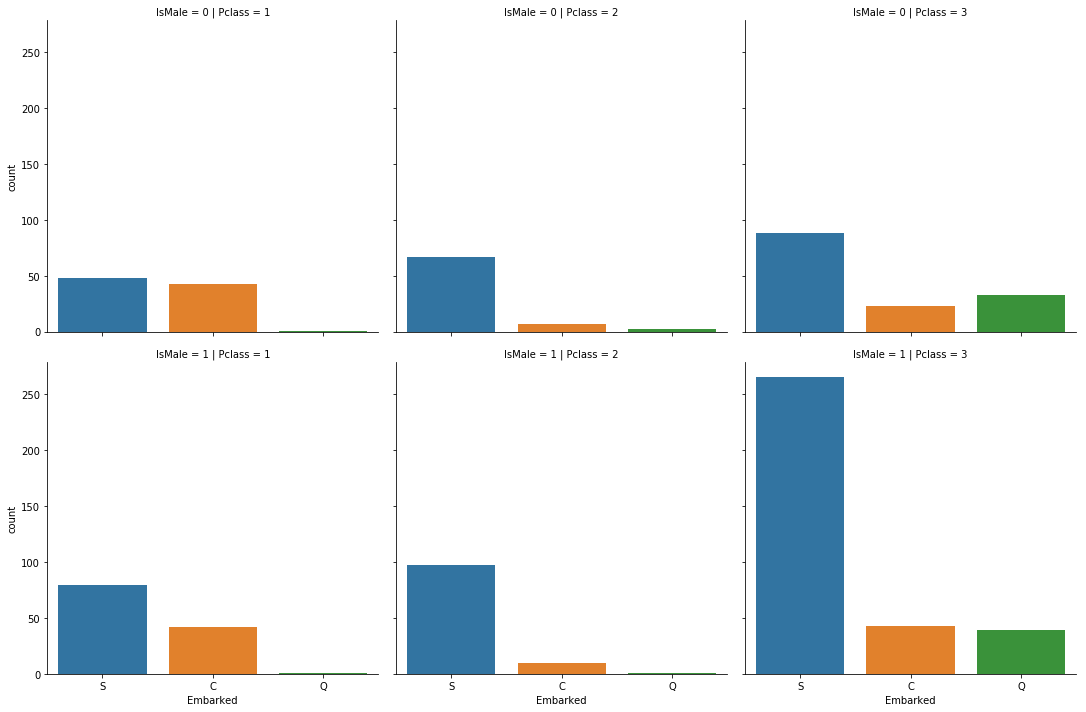

In [20]:
# Plot relationship between Embarked, Pclass, and IsMale
_ = sns.factorplot(x='Embarked', col='Pclass', row='IsMale', data=train, kind='count')

In [21]:
# Passengers grouped by Embarked, Pclass, and IsMale
embarked_corr = (train[['Survived', 'Embarked', 'Pclass', 'IsMale']].groupby(['Embarked', 'Pclass', 'IsMale'])                                            
                                                                    .agg(['count', 'sum', 'mean']))
embarked_corr.columns = embarked_corr.columns.droplevel(0)
embarked_corr.columns = ['Total', 'Survived', 'Rate']
embarked_corr

Total  Survived      Rate
Embarked Pclass IsMale                           
C        1      0          43        42  0.976744
                1          42        17  0.404762
         2      0           7         7  1.000000
                1          10         2  0.200000
         3      0          23        15  0.652174
                1          43        10  0.232558
Q        1      0           1         1  1.000000
                1           1         0  0.000000
         2      0           2         2  1.000000
                1           1         0  0.000000
         3      0          33        24  0.727273
                1          39         3  0.076923
S        1      0          48        46  0.958333
                1          79        28  0.354430
         2      0          67        61  0.910448
                1          97        15  0.154639
         3      0          88        33  0.375000
                1         265        34  0.128302

We see that in `Southampton (S)` a high number of 3rd class males embarked the Titanic so a low survival rate is to be expected. A high number of 1st class passengers embarked in `Cherbourg (C)` so we see a high survival rate. In `Queenstown (Q)`, however, the chart shows something that I was not expecting given the following observations:
- the vast majority of passengers are 3rd class passengers;
- the number of males and females is comparable.

Given these conditions, survival rate should be correlated only to `IsMale`, and that is true for females; males however end-up with half the survival rate. Though, this is a sample of 42 males in a population of 577, so it's not enough to convince me that `Embarked` is independently correlated to survival. `Embarked` is dropped.

In [22]:
train.drop(columns='Embarked', inplace=True)
test.drop(columns='Embarked', inplace=True)

## Fare

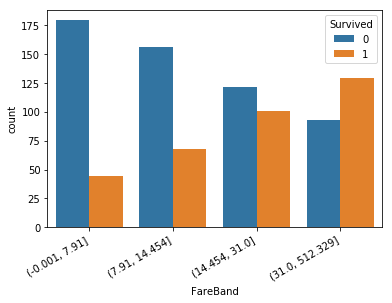

In [23]:
no_fare_bins = 4
train['FareBand'], fare_bins = pd.qcut(train['Fare'], no_fare_bins, retbins=True)
_ = sns.countplot(x='FareBand', hue='Survived', data=train)
_ = plt.xticks(rotation=30, ha='right')

One might think that `Fare` and `Pclass` are highly correlated, let's see if that is true... 

/home/davidtvs/datascience/kaggle/Titanic/titanic-env/lib/python3.5/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


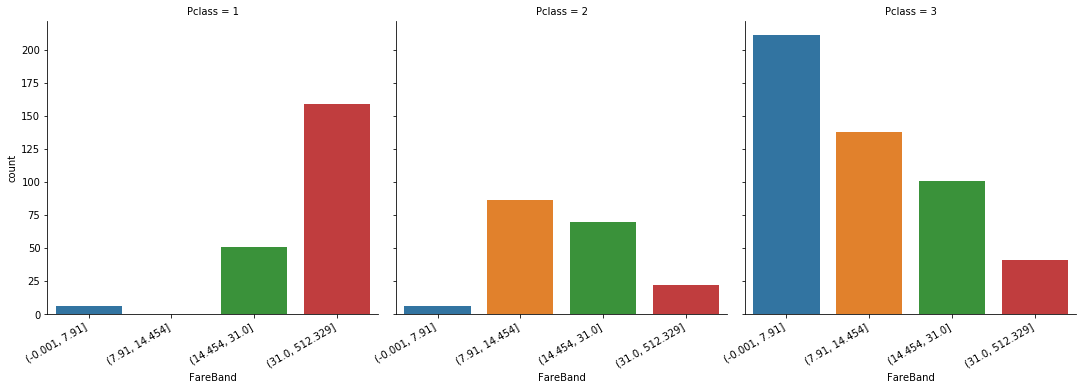

In [24]:
# Plot relationship between FareBand and Pclass
g = sns.factorplot(x='FareBand', col='Pclass', data=train, kind='count')
_ = g.set_xticklabels(rotation=30, ha='right')

In [25]:
# Group passengers by FareBand and Pclass
fare_corr = (train[['Survived', 'FareBand', 'Pclass']].groupby(['Pclass', 'FareBand'])
                                                      .agg(['count', 'sum', 'mean']))
fare_corr.columns = fare_corr.columns.droplevel(0)
fare_corr.columns = ['Total', 'Survived', 'Rate']
fare_corr

Total  Survived      Rate
Pclass FareBand                                  
1      (-0.001, 7.91]       6         0  0.000000
       (14.454, 31.0]      51        27  0.529412
       (31.0, 512.329]    159       109  0.685535
2      (-0.001, 7.91]       6         0  0.000000
       (7.91, 14.454]      86        33  0.383721
       (14.454, 31.0]      70        42  0.600000
       (31.0, 512.329]     22        12  0.545455
3      (-0.001, 7.91]     211        44  0.208531
       (7.91, 14.454]     138        35  0.253623
       (14.454, 31.0]     101        32  0.316832
       (31.0, 512.329]     41         8  0.195122

There is correlation, but there is also some unique information that we can observe in `Fare`, particularly for 3rd class passengers:
1. many bought expensive tickets
2. survival is not related to fare, though there is a spike in the 10.5 to 21.7 fare band

Since the majority of passengers are 3rd class I think this information might help to predict who survives and who doesn't.

Fare bands should be encoded as integers since there is a natural order to the feature. Before including it we also need to fill the missing entry in Fare. **Note:** I am only filling after the analysis because the ammount of missing data is not significant.

In [26]:
# Fill missing fares
dataset = pd.concat([train, test], sort=True)
dataset['Fare'].fillna(dataset['Fare'].median(), inplace=True)
print("No. of NaN values in Fare: {}".format(dataset['Fare'].isna().sum() / len(train)))

train = dataset.iloc[:train_len].copy()
test = dataset.iloc[train_len:].copy()

No. of NaN values in Fare: 0.0


In [27]:
# Convert fare bands to integers and drop the 'Fare' column
train['FareBand'] = train['FareBand'].astype('category').cat.codes
train.drop(columns='Fare', inplace=True)

# Apply the fare bands computed from the training set, convert to integers and drop the 'Fare' column
test['FareBand'] = pd.cut(test['Fare'], fare_bins)
test['FareBand'] = test['FareBand'].astype('category').cat.codes
test.drop(columns=['Fare'], inplace=True)

## Enginnering Groups of Passengers (InGroups)

A passenger belongs to a group if he shares one of the following features with at least one other passenger:
1. ticket number;
2. combination of: surname + PClass + ticket number (excluding last digit) + embarked.

Note: Could also take advantage of Parch and SibSp but since errors have been found with those features I won't use them.

In [28]:
# Create the new feature for the whole dataset 
# (I am using _train and _test because train and test no longer contain 'Embarked')
dataset = pd.concat([_train, _test], sort=True)


### Groups by ticket number

In [29]:
# Groups that shares the same ticket number
ticket_count = dataset['Ticket'].value_counts()
shared_tickets = ticket_count[ticket_count > 1].index
group_tickets = dataset['Ticket'].apply(lambda x: x in shared_tickets)

### Groups by surname + PClass + ticket number (excluding last digit) + embarked (SPTE)

In [30]:
surname = dataset['Name'].apply(lambda x: x[:x.find(',')])
ticket = dataset['Ticket'].apply(lambda x: x[:-1])

spte_id = (surname.astype(str) + '-' + dataset['Pclass'].astype(str) + '-'
           + ticket.astype(str) + '-' + dataset['Embarked'].astype(str) + '-' + dataset['Fare'].astype(str))

spte_count = spte_id.value_counts()
shared_spte = spte_count[spte_count > 1].index
group_spte = spte_id.apply(lambda x: x in shared_spte)

### Merging the groups

Add the `InGroup` feature to the `train` and `test` datasets. Also drop the features: `Name`, `SibSp`, `Parch`, and `Ticket`. 

In [31]:
# Merge groups
dataset['InGroup'] = group_tickets | group_spte

# Convert the bool values to ints
train['InGroup'] = dataset.iloc[:train_len, -1].astype(int)
test['InGroup'] = dataset.iloc[train_len:, -1].astype(int)

train.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket'], inplace=True)
test.drop(columns=['Name', 'SibSp', 'Parch', 'Ticket', 'Survived'], inplace=True)

train.head()

,Age,FareBand,IsMale,Pclass,Survived,InGroup
0,2,0,1,3,0.0,0
1,4,3,0,1,1.0,1
2,3,1,0,3,1.0,0
3,4,3,0,1,1.0,1
4,4,1,1,3,0.0,0


InGroup
0    0.283516
1    0.488532
Name: Survived, dtype: float64

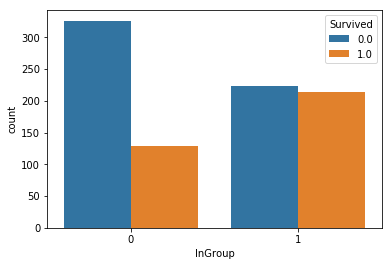

In [32]:
_ = sns.countplot(x='InGroup', hue='Survived', data=train)
train.groupby('InGroup')['Survived'].mean()

Looks like there really is strength in numbers: 49% of the passengers travelling in groups survived while only 28% of the ones travelling alone managed to survive.

# Modeling

## Cross-validation

Evaluate, using cross-validation, which of the following classifiers performs best in our treaining data:
- Decision Tree
- Random Forest
- Extra Trees
- AdaBoost
- Logistic Regression
- K-nearest neighbors
- Linear SVC
- SVC

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC


# Split the training set into samples and targets
X_train = train.drop(columns='Survived')
Y_train = train['Survived'].astype(int)

# Test set samples to predict
X_test = test

# Scale features such that the mean is 0 and standard deviation is 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Number of cross-validation folds
k_folds = 10

# Create a dictionary containing the instance of the models, scores, mean accuracy and standard deviation
classifiers = {
    'name': ['DecisionTree', 'RandomForest', 'ExtraTrees', 'AdaBoost', 'LogReg', 'KNN', 'LinearSVC', 'SVC'],
    'models': [DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreesClassifier(), AdaBoostClassifier(),
               LogisticRegression(), KNeighborsClassifier(), LinearSVC(), SVC(gamma='auto')], 
    'scores': [],
    'acc_mean': [],
    'acc_std': []
}

# Run cross-validation and store the scores
for model in classifiers['models']:
    score = cross_val_score(model, X_train, Y_train, cv=k_folds, n_jobs=4)
    classifiers['scores'].append(score)
    classifiers['acc_mean'].append(score.mean())
    classifiers['acc_std'].append(score.std())    

# Create a nice table with the results
classifiers_df = pd.DataFrame({
    'Model Name': classifiers['name'],
    'Accuracy': classifiers['acc_mean'],
    'Std': classifiers['acc_std']
}, columns=['Model Name', 'Accuracy', 'Std']).set_index('Model Name')

classifiers_df.sort_values('Accuracy', ascending=False)

,Accuracy,Std
Model Name,,
KNN,0.836213,0.035798
DecisionTree,0.833979,0.038887
ExtraTrees,0.833966,0.039263
RandomForest,0.824952,0.028542
SVC,0.809158,0.035034
LinearSVC,0.790081,0.034721
LogReg,0.789008,0.019848
AdaBoost,0.786748,0.021985


From the tested models I decided to drop those that have an accuracy below 0.8. So that leaves us with:
- Decision Tree
- Extra Trees
- Random Forest
- K-nearest neighbors
- SVC

## Tunning hyper-parameters

To further improve the models we can tune their hyper-parameters using randomized parameter optimization or grid search. I chose randomized parameter optimization since it typically performs just as well as grid search but with much fewer iterations.

In [34]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print()

# Number of iterations
n_iter_search = 60

### Decision Tree

In [35]:
tc = DecisionTreeClassifier()
rand_param = {
    'max_depth': np.append(randint(1, 10).rvs(10), None),
    'max_features': randint(1, X_train.shape[1]), # From 1 to number of features is a good range
    'min_samples_split': randint(2, 10)
}

tc_search = RandomizedSearchCV(tc, param_distributions=rand_param, n_iter=n_iter_search, cv=k_folds,
                                n_jobs=4, verbose=1, iid=False)
tc_search.fit(X_train, Y_train)
report(tc_search.cv_results_)

tc_best = tc_search.best_estimator_

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Model with rank: 1
Mean validation score: 0.8384 (std: 0.0392)
Parameters: {'max_depth': None, 'max_features': 2, 'min_samples_split': 7}

Model with rank: 2
Mean validation score: 0.8362 (std: 0.0433)
Parameters: {'max_depth': None, 'max_features': 3, 'min_samples_split': 9}

Model with rank: 3
Mean validation score: 0.8351 (std: 0.0403)
Parameters: {'max_depth': None, 'max_features': 2, 'min_samples_split': 5}



[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:    0.4s finished


### Random Forest

In [36]:
rfc = RandomForestClassifier(n_estimators=100)
rand_param = {
    'bootstrap': [True, False],
    'max_depth': np.append(randint(1, 10).rvs(10), None),
    'max_features': randint(1, X_train.shape[1]), # From 1 to number of features is a good range
    'min_samples_split': randint(2, 10)
}

rfc_search = RandomizedSearchCV(rfc, param_distributions=rand_param, n_iter=n_iter_search, cv=k_folds,
                                n_jobs=4, verbose=1, iid=False)
rfc_search.fit(X_train, Y_train)
report(rfc_search.cv_results_)

rfc_best = rfc_search.best_estimator_

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   12.0s


Model with rank: 1
Mean validation score: 0.8441 (std: 0.0375)
Parameters: {'max_depth': None, 'max_features': 3, 'bootstrap': True, 'min_samples_split': 5}

Model with rank: 2
Mean validation score: 0.8407 (std: 0.0370)
Parameters: {'max_depth': None, 'max_features': 2, 'bootstrap': True, 'min_samples_split': 6}

Model with rank: 3
Mean validation score: 0.8396 (std: 0.0403)
Parameters: {'max_depth': 9, 'max_features': 3, 'bootstrap': False, 'min_samples_split': 8}



[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:   18.8s finished


### Extra Trees

In [37]:
etc = ExtraTreesClassifier(n_estimators=100)
rand_param = {
    'bootstrap': [True, False],
    'max_depth': np.append(randint(1, 10).rvs(10), None),
    'max_features': randint(1, X_train.shape[1]), # From 1 to number of features is a good range
    'min_samples_split': randint(2, 10)
}

etc_search = RandomizedSearchCV(etc, param_distributions=rand_param, n_iter=n_iter_search, cv=k_folds,
                                n_jobs=4, verbose=1, iid=False)
etc_search.fit(X_train, Y_train)
report(etc_search.cv_results_)

etc_best = etc_search.best_estimator_

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   11.6s


Model with rank: 1
Mean validation score: 0.8396 (std: 0.0401)
Parameters: {'max_depth': 9, 'max_features': 3, 'bootstrap': True, 'min_samples_split': 4}

Model with rank: 2
Mean validation score: 0.8395 (std: 0.0390)
Parameters: {'max_depth': 7, 'max_features': 3, 'bootstrap': False, 'min_samples_split': 3}

Model with rank: 3
Mean validation score: 0.8395 (std: 0.0386)
Parameters: {'max_depth': None, 'max_features': 4, 'bootstrap': False, 'min_samples_split': 9}



[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:   18.8s finished


### K-nearest neighbors

In [38]:
knn = KNeighborsClassifier()
rand_param = {
    'algorithm': ['auto'],
    'n_neighbors': randint(1, 25),
    'leaf_size': randint(1, 50),
    'weights': ['uniform', 'distance']
}

knn_search = RandomizedSearchCV(knn, param_distributions=rand_param, n_iter=n_iter_search, cv=k_folds,
                                n_jobs=4, verbose=1, iid=False)
knn_search.fit(X_train, Y_train)
report(knn_search.cv_results_)

knn_best = knn_search.best_estimator_

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Model with rank: 1
Mean validation score: 0.8418 (std: 0.0348)
Parameters: {'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 13, 'n_neighbors': 8}

Model with rank: 1
Mean validation score: 0.8418 (std: 0.0348)
Parameters: {'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 33, 'n_neighbors': 8}

Model with rank: 3
Mean validation score: 0.8373 (std: 0.0351)
Parameters: {'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 35, 'n_neighbors': 10}

Model with rank: 3
Mean validation score: 0.8373 (std: 0.0351)
Parameters: {'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 10}

Model with rank: 3
Mean validation score: 0.8373 (std: 0.0382)
Parameters: {'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 21, 'n_neighbors': 7}

Model with rank: 3
Mean validation score: 0.8373 (std: 0.0337)
Parameters: {'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 38, 'n_neighbors': 9}


[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:    1.2s finished


### SVC

In [39]:
svc = SVC(probability=True)
rand_param = {
    'kernel': ['rbf'],
    'C': randint(1, 1000),
    'gamma': uniform(1e-3, 1)
}

svc_search = RandomizedSearchCV(svc, param_distributions=rand_param, n_iter=n_iter_search, cv=k_folds,
                                n_jobs=4, verbose=1, iid=False)
svc_search.fit(X_train, Y_train)
report(svc_search.cv_results_)

svc_best = svc_search.best_estimator_

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Done  98 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 273 tasks      | elapsed:   21.5s
[Parallel(n_jobs=4)]: Done 564 tasks      | elapsed:   45.0s


Model with rank: 1
Mean validation score: 0.8351 (std: 0.0340)
Parameters: {'kernel': 'rbf', 'gamma': 0.9556419037907851, 'C': 320}

Model with rank: 1
Mean validation score: 0.8351 (std: 0.0340)
Parameters: {'kernel': 'rbf', 'gamma': 0.9308976056994236, 'C': 52}

Model with rank: 1
Mean validation score: 0.8351 (std: 0.0340)
Parameters: {'kernel': 'rbf', 'gamma': 0.974399475948769, 'C': 255}

Model with rank: 1
Mean validation score: 0.8351 (std: 0.0340)
Parameters: {'kernel': 'rbf', 'gamma': 0.8918644220551998, 'C': 444}

Model with rank: 1
Mean validation score: 0.8351 (std: 0.0340)
Parameters: {'kernel': 'rbf', 'gamma': 0.8984243216297588, 'C': 849}

Model with rank: 1
Mean validation score: 0.8351 (std: 0.0340)
Parameters: {'kernel': 'rbf', 'gamma': 0.9225947312275625, 'C': 890}

Model with rank: 1
Mean validation score: 0.8351 (std: 0.0340)
Parameters: {'kernel': 'rbf', 'gamma': 0.959903880750093, 'C': 554}

Model with rank: 1
Mean validation score: 0.8351 (std: 0.0340)
Parameter

[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed:   47.8s finished


# Ensemble modeling

We can combine the best estimators into a single model using a Soft Voting/Majority Rule classifier (`VotingClassifier`). Ensembles can only improve over individual models if they are not highly correlated. So, let's start by evaluating the Jaccard similarity between the predictions of each individual model.

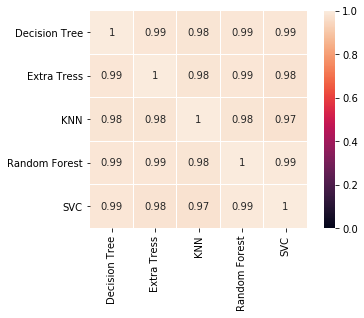

In [40]:
from sklearn.metrics import jaccard_similarity_score


tc_pred = tc_best.predict(X_test)
rfc_pred = rfc_best.predict(X_test)
etc_pred = etc_best.predict(X_test)
knn_pred = knn_best.predict(X_test)
svc_pred = svc_best.predict(X_test)

# Make a dataframe with the predictions from all models
pred_df = pd.DataFrame({'Decision Tree': tc_pred,
                       'Random Forest': rfc_pred,
                       'Extra Tress': etc_pred,
                       'KNN': knn_pred,
                       'SVC': svc_pred})

jsim_df = pd.DataFrame(np.nan, columns=pred_df.columns, index=pred_df.columns)
for i in pred_df.columns:
    for j in pred_df.loc[:, i:].columns:
        jsim_df.loc[i, j] = jaccard_similarity_score(pred_df[i], pred_df[j])
        jsim_df.loc[j, i] = jsim_df.loc[i, j]

_ = sns.heatmap(jsim_df, linewidths=0.1, vmax=1.0, vmin=0, square=True, linecolor='white', annot=True)

Doesn't look good for ensembling, the predictions are very similar to one another, therefore it will not be able to balance out weaknesses of the individual models.

Just to be sure, and as learning experience, let's create the ensemble and check how it performs.

In [41]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
import warnings


warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

estimators = [('Decision Tree', tc_best), ('Random Forest', rfc_best), ('Extra Trees', etc_best),
              ('KNN', knn_best), ('SVC', svc_best)]

eclf = VotingClassifier(estimators=estimators)
ensemble_param = {'voting': ['hard', 'soft']}

eclf_search = GridSearchCV(eclf, param_grid=ensemble_param, cv=k_folds, n_jobs=4, verbose=1)
eclf_search.fit(X_train, Y_train)
report(eclf_search.cv_results_)

eclf_best = eclf_search.best_estimator_

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.0s finished


Model with rank: 1
Mean validation score: 0.8406 (std: 0.0384)
Parameters: {'voting': 'hard'}

Model with rank: 2
Mean validation score: 0.8384 (std: 0.0376)
Parameters: {'voting': 'soft'}



It performs slightly worse than our best individual model (KNN) and just as well as the remaining models.

# Predictions and submission

We can now generate predictions and the submission file using our best model: K-Nearest Neighbors.

In [42]:
submission_df = pd.DataFrame({'PassengerId': _test['PassengerId'], 'Survived': knn_pred})
submission_df.to_csv("submission.csv", index=False)